# AutoEncoder

어제 다뤘던 이동통신 고객 이탈 데이터를 이용하여, AE 모델을 생성하고 예측해 봅시다.



## 1.환경준비

### (1) 라이브러리 로딩

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import precision_recall_curve

from keras.models import Sequential
from keras.layers import Dense
from keras.backend import clear_session
from keras.optimizers import Adam

### (2) 필요 함수들 생성

#### ① reconstruction error plot

> * input과 output의 차이(mse)를 계산하고
* 시각화 합니다.



In [ ]:
def recon_err_plot(x, x_pred, y, threshold=0):
    # treshold : 우리가 지정해줘야 함.(어떻게?)

    # 재구성 오차 계산
    mse = np.mean(np.power(x - x_pred, 2), axis=1)
    error_df = pd.DataFrame({'recon_err': mse, 'y': y})
    error_df = error_df.reset_index()

    # 재구성 오차 그래프
    groups = error_df.groupby('y')
    fig, ax = plt.subplots()
    for name, group in groups:
        ax.plot(group.index, group.recon_err, marker='o', ms=3.5, linestyle='',
                label= "Abnormal" if name == 1 else "Normal")
    ax.hlines(threshold, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
    ax.legend()
    plt.title("Reconstruction error for each data point")
    plt.ylabel("Reconstruction error")
    plt.xlabel("Data point index")
    plt.show()

    return error_df

#### ② precision, recall, f1 curve

> * sklearn에서는 precision, recall curve만 제공됩니다.
* 그래서, f1 curve도 추가해서 구하고, plot을 그립니다.



In [ ]:
def prec_rec_f1_curve(y, score, pos = 1) :
    precision, recall, thresholds  = precision_recall_curve(y, score, pos_label=1)
    f1 = 2 / (1/precision + 1/recall)

    plt.figure(figsize = (8, 6))
    plt.plot(thresholds, np.delete(precision, -1), label = 'precision')
    plt.plot(thresholds, np.delete(recall, -1), label = 'recall')
    plt.plot(thresholds, np.delete(f1, -1), label = 'f1')
    plt.xlabel('Anomaly Score')
    plt.legend()
    plt.grid()
    plt.show()

    return precision, recall, f1, thresholds

#### ③ threshold로 잘랐을 때, 분류 평가 함수


In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

def classification_report2(y, pred, thresholds):
    pred_temp = np.where(pred >= thresholds , 1, 0)

    print('< confusion matrix >\n')
    print(confusion_matrix(y, pred_temp))
    print('\n' + '='*60 + '\n')

    print('< classification_report >\n')
    print(classification_report(y, pred_temp))

#### ④ DL 학습곡선 그리기


In [ ]:
def plot_learning_curve(history) :
    plt.figure(figsize = (10,6))
    plt.plot(history['loss'], label='Train', marker = '.')
    plt.plot(history['val_loss'], label='Validation', marker = '.')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.grid()
    plt.show()

### (3) 데이터셋 불러오기

In [ ]:
# secom
path = "https://raw.githubusercontent.com/DA4BAM/dataset/master/secom_9.csv"
data = pd.read_csv(path)

data['label'] = 0
data.loc[data['defeat']== 'defeat', 'label']= 1
data.drop(['datetime','defeat'], axis = 1, inplace=True)

In [ ]:
data.shape

(1567, 53)

In [ ]:
data.head()

,v021,v087,v088,v089,v114,v115,v116,v117,v118,v120,...,v528,v571,v572,v573,v574,v575,v576,v577,v578,label
0,1.4026,2.3895,0.9690,1747.6049,0.9460,0.0,748.6115,0.9908,58.4306,0.9804,...,6.6926,533.8500,2.1113,8.95,0.3157,3.0624,0.1026,1.6765,14.9509,0
1,1.3825,2.3754,0.9894,1931.6464,0.9425,0.0,731.2517,0.9902,58.6680,0.9731,...,8.8370,535.0164,2.4335,5.92,0.2653,2.0111,0.0772,1.1065,10.9003,0
2,1.4123,2.4532,0.9880,1685.8514,0.9231,0.0,718.5777,0.9899,58.4808,0.9772,...,6.4568,535.0245,2.0293,11.21,0.1882,4.0923,0.0640,2.0952,9.2721,1
3,1.4011,2.4004,0.9904,1752.0968,0.9564,0.0,709.0867,0.9906,58.6635,0.9761,...,6.4865,530.5682,2.0253,9.33,0.1738,2.8971,0.0525,1.7585,8.5831,0
4,1.3888,2.4530,0.9902,1828.3846,0.9424,0.0,796.5950,0.9908,58.3858,0.9628,...,6.3745,532.0155,2.0275,8.83,0.2224,3.1776,0.0706,1.6597,10.9698,0


In [ ]:
data['label'].value_counts()

0    1463
1     104
Name: label, dtype: int64

In [ ]:
data['label'].value_counts(normalize = True)

0    0.933631
1    0.066369
Name: label, dtype: float64

## 2.데이터 준비

### (1) 데이터 분할

In [ ]:
target = 'label'
x = data.drop(target, axis = 1)
y = data.loc[:,target]

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = .3, random_state=20)

In [ ]:
x_train.shape, y_train.shape

((1096, 52), (1096,))

### (2) 스케일링

In [ ]:
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)

### (3) Normal 데이터만 뽑기

In [ ]:
# 학습을 위해서는 Normal 데이터만 이용한다.
x_train0 = x_train[y_train == 0]

In [ ]:
x_train0.shape

(1018, 52)

## 3.모델링 : AE

### (1) 학습

#### 1) 모델 설계

In [ ]:
input_dim = x_train0.shape[1]
input_dim

52

In [ ]:
input_dim = x_train0.shape[1] #num of columns

clear_session()
autoencoder = Sequential([Dense(32, input_shape = (input_dim,), activation = 'relu'),
                          Dense(16, activation="relu"),
                          Dense(32, activation='relu'),
                          Dense(input_dim, activation='relu')])

autoencoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                1696      
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 32)                544       
                                                                 
 dense_3 (Dense)             (None, 52)                1716      
                                                                 
Total params: 4,484
Trainable params: 4,484
Non-trainable params: 0
_________________________________________________________________


#### 2) compile + 학습

In [ ]:
autoencoder.compile(optimizer='adam', loss='mse')

history = autoencoder.fit(x=x_train0, y=x_train0,
                          epochs=50, batch_size=64,
                          validation_split = .2).history

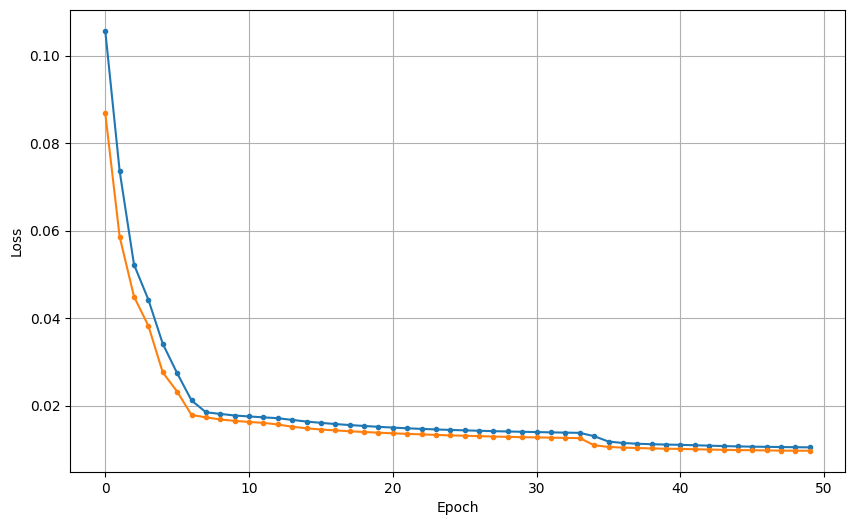

In [ ]:
plot_learning_curve(history)

### (2) 예측 및 Reconstruction Error 계산

#### 1) 예측

In [ ]:
pred = autoencoder.predict(x_val)
pred

In [ ]:
x_val.shape, pred.shape

((471, 52), (471, 52))

#### 2) 재구성 오차 계산

In [ ]:
result = recon_err_plot(x_val, pred, y_val, .15)

In [ ]:
result.head()

,index,recon_err,y
0,1227,0.006434,1
1,545,0.008178,0
2,1013,0.008968,0
3,1281,0.013961,0
4,522,0.005047,0


#### 3) Threshold 찾기 : precision_recall_f1_curve

<ipython-input-3-0b309618100c>:3: RuntimeWarning: divide by zero encountered in true_divide
  f1 = 2 / (1/precision + 1/recall)


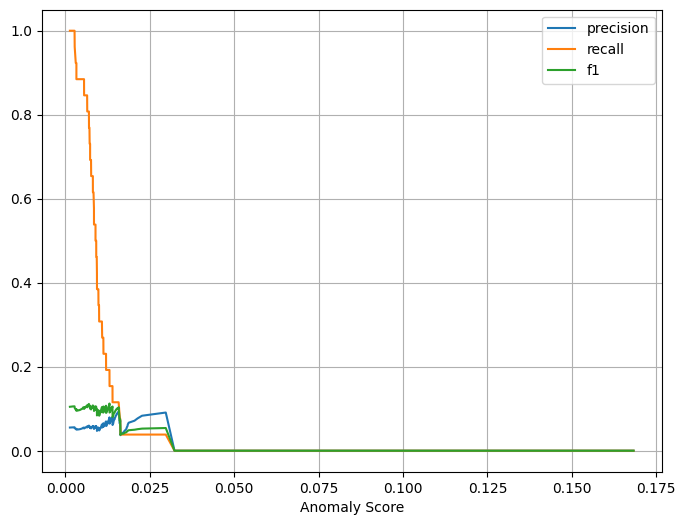

In [ ]:
precision, recall, f1, thresholds = prec_rec_f1_curve(result['y'], result['recon_err'])

In [ ]:
thres_f1_max = thresholds[np.argmax(f1)]
thres_f1_max

0.01304971037854245

#### 4) f1을 최대화 하는 threshold 값으로 잘라서 평가

In [ ]:
classification_report2(result['y'], result['recon_err'], thres_f1_max)

< confusion matrix >

[[387  58]
 [ 21   5]]


< classification_report >

              precision    recall  f1-score   support

           0       0.95      0.87      0.91       445
           1       0.08      0.19      0.11        26

    accuracy                           0.83       471
   macro avg       0.51      0.53      0.51       471
weighted avg       0.90      0.83      0.86       471



## 4.실습 : 사기거래 탐지

### (1) 데이터 준비

* 데이터 로딩

In [ ]:
path = "https://raw.githubusercontent.com/DA4BAM/dataset/master/creditcard_simple.csv"
data = pd.read_csv(path)

target = 'fraud'
x = data.drop(target, axis = 1)
y = data.loc[:,target]

In [ ]:
data.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,amount,fraud
0,0.733,-0.544,-0.601,0.020,0.181,0.172,-1.768,-0.083,-0.323,0.110,-0.019,-0.457,-0.088,0.167,0.270,-0.513,-0.006,0.044,199.45,0
1,1.942,-0.056,1.319,1.197,0.367,0.265,0.006,0.310,-0.522,-0.223,-0.268,-0.595,0.345,-1.040,-0.432,0.280,-0.018,-0.057,1.98,0
2,-0.223,1.182,0.166,-1.328,0.151,-0.101,-0.489,0.476,0.034,-0.174,0.404,1.288,-0.076,0.071,-0.787,-0.218,0.382,0.259,0.89,0
3,0.672,-1.261,-0.602,-0.866,-0.335,0.875,0.786,0.012,1.338,0.655,0.201,0.078,-0.527,0.133,0.745,0.041,-0.074,0.049,340.31,0
4,-3.368,0.099,0.458,-1.572,0.672,-3.188,1.019,-0.590,1.930,0.265,0.861,1.249,1.851,-0.117,1.220,0.000,1.036,0.004,320.01,1


* 데이터 분할

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = 6000, random_state=20)

* 스케일링

In [ ]:
scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_val = scaler.transform(x_val)

In [ ]:
x_train.shape

(14000, 19)

* Normal 데이터만 저장

In [ ]:
x_train0 = x_train[y_train == 0]

### (2) 모델링 : AE

#### 1) 학습

* 모델 설계
    * 아래 구조를 참조하되 여러분이 원하는 대로 생성을 해 봅시다.

_________________________________________________________________
 Layer (type)                Output Shape              
_________________________________________________________________
dense (Dense)               (None, 32)                     
                                                                 
 dense_1 (Dense)             (None, 16)                     
                                                                 
 dense_2 (Dense)             (None, 8)                      
                                                                 
 dense_3 (Dense)             (None, 16)                     
                                                                 
 dense_4 (Dense)             (None, 32)                     
                                                                 
 dense_5 (Dense)             (None, 19)                     
_________________________________________________________________


In [ ]:
x_train0.shape

(13661, 19)

In [72]:
input_dim = x_train0.shape[1] #num of columns

clear_session()
model = Sequential([Dense(32, input_shape = (input_dim,), activation = 'relu'),
                          Dense(16, activation="relu"),
                          Dense(8, activation="relu"),
                          Dense(16, activation="relu"),
                          Dense(32, activation='relu'),
                          Dense(input_dim, activation='relu')])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                640       
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 8)                 136       
                                                                 
 dense_3 (Dense)             (None, 16)                144       
                                                                 
 dense_4 (Dense)             (None, 32)                544       
                                                                 
 dense_5 (Dense)             (None, 19)                627       
                                                                 
Total params: 2,619
Trainable params: 2,619
Non-trainabl

* compile + 학습

In [ ]:
model.compile(optimizer= Adam(learning_rate = 0.01), loss='mse')

history = model.fit(x=x_train0, y=x_train0, epochs=50, batch_size=64,
                          validation_split = .2).history

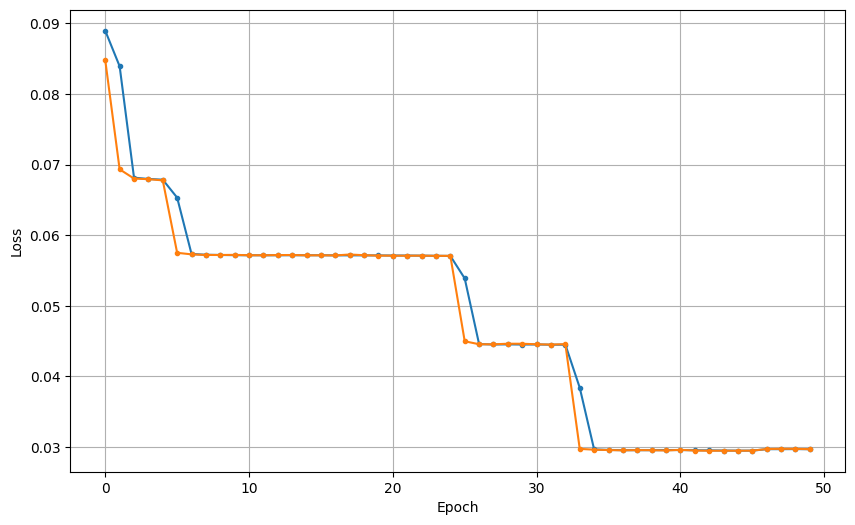

In [74]:
plot_learning_curve(history)

#### 2) 예측 및 검증

* 예측

In [75]:
pred = model.predict(x_val)

188/188 [==============================] - 0s 2ms/step


* 재구성 오차 그래프

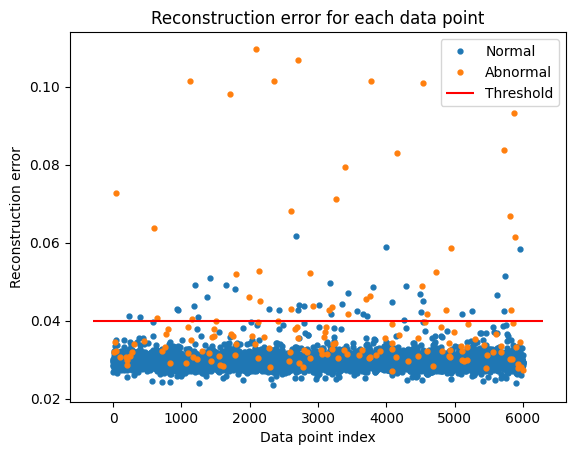

In [80]:
result = recon_err_plot(x_val, pred, y_val, 0.04)

* precision_recall_f1_curve

<ipython-input-3-0b309618100c>:3: RuntimeWarning: divide by zero encountered in true_divide
  f1 = 2 / (1/precision + 1/recall)


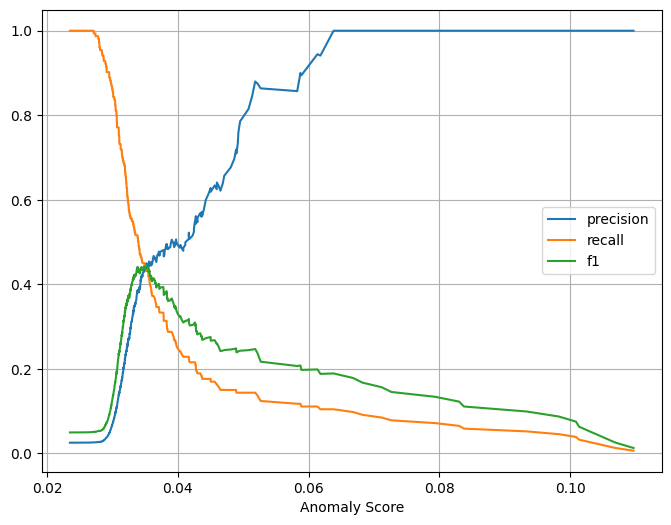

In [77]:
_, _, f1, thresholds = prec_rec_f1_curve(result['y'], result['recon_err'])

* f1을 최대화 하는 threshold 값으로 평가

In [78]:
thres_f1_max = thresholds[np.argmax(f1)]
thres_f1_max

0.0352057995129054

In [79]:
classification_report2(result['y'], result['recon_err'], thres_f1_max)

< confusion matrix >

[[5765   82]
 [  86   67]]


< classification_report >

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      5847
           1       0.45      0.44      0.44       153

    accuracy                           0.97      6000
   macro avg       0.72      0.71      0.71      6000
weighted avg       0.97      0.97      0.97      6000

